# PCA for bond analysis

Ver los siguientes links:

+ Sección $II.2$, *Market Risk Analysis, Volume II: Practical Financial Econometrics*, Carol Alexander.
+ [*Principal Component Analysis (PCA) with Scikit-learn*](https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0)
+ [*Applying PCA to the yield curve - the hard way*](https://towardsdatascience.com/applying-pca-to-the-yield-curve-4d2023e555b3)
+ [*How to Analyze Bonds Lika a Quant*](https://towardsdatascience.com/how-to-trade-bonds-like-a-quant-da2c297958ef)
+ [Practical PCA for yield curve modeling](https://allaccountstaken.medium.com/practical-pca-for-yield-curve-modeling-e3838e17b2bb)



In [1]:
import pandas as pd
import numpy as np
import requests
import xml.etree.cElementTree as xml
import dateutil
import datetime
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()


In [2]:
class TreasuryData:
    """
    Clase para descargar los datos de treasuries.
    """    
    def __init__(self):
        
        self.TERM_CONVERSION = {
            'BC_10YEAR': 10,
            'BC_1MONTH': 1. / 12.,
            'BC_2MONTH': 2. / 12.,
            'BC_1YEAR': 1,
            'BC_20YEAR': 20,
            'BC_2YEAR': 2,
            'BC_30YEAR': 30,
            'BC_3MONTH': 0.25,
            'BC_3YEAR': 3,
            'BC_5YEAR': 5,
            'BC_6MONTH': 0.5,
            'BC_7YEAR': 7
        }
        self.BASE_URL = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData'

    def get_yields(self)->pd.DataFrame:
        
        req = requests.get(self.BASE_URL)
        etree = xml.ElementTree(xml.fromstring(req.text))
        root = etree.getroot()

        recs = []

        for element in root:
            if element.tag is not None:
                if element.tag.endswith('entry'):
                    entry_children = element.iter()
                    curdate_dt = None

                    for entry_child in entry_children:
                        if entry_child.tag.endswith('NEW_DATE'):
                            curdate_dt = dateutil.parser.parse(entry_child.text)

                        elif re.search(r'BC_\d+[a-zA-Z]+$', entry_child.tag):
                            term = re.search('BC_\d+[a-zA-Z]+$', entry_child.tag).group(0)
                            if entry_child.text is None:
                                continue
                            else:
                                rate=float(entry_child.text)
                                recs.append({'term': term, 'yield': rate, 'dt': curdate_dt})

        df = pd.DataFrame(recs)
        
        df['termlength'] = df['term'].apply(lambda x: self.TERM_CONVERSION.get(x))
        
        df = df.dropna(axis=0).set_index(['dt', 'termlength']).sort_index(level=0).unstack(level=1)['yield']
        
        df.columns = [round(col, 3) for col in df.columns]
        
        return df

In [3]:
treasury = TreasuryData()
yields = treasury.get_yields()

In [4]:
yields.head()

,0.083,0.167,0.250,0.500,1.000,2.000,3.000,5.000,7.000,10.000,20.000,30.000
dt,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09


In [5]:
yields.tail()

,0.083,0.167,0.250,0.500,1.000,2.000,3.000,5.000,7.000,10.000,20.000,30.000
dt,,,,,,,,,,,,
2021-10-25,0.07,0.10,0.06,0.06,0.14,0.47,0.76,1.19,1.47,1.64,2.07,2.09
2021-10-26,0.06,0.08,0.06,0.06,0.14,0.47,0.77,1.20,1.46,1.63,2.03,2.05
2021-10-27,0.06,0.07,0.06,0.07,0.12,0.50,0.77,1.16,1.41,1.54,1.93,1.95
2021-10-28,0.06,0.10,0.06,0.06,0.15,0.50,0.77,1.18,1.44,1.57,1.98,1.96
2021-10-29,0.06,0.08,0.05,0.07,0.15,0.48,0.75,1.18,1.44,1.55,1.98,1.93


In [6]:
yields.isna().sum()

0.083     2899
0.167     7205
0.250        3
0.500        0
1.000        0
2.000        0
3.000        0
5.000        0
7.000        0
10.000       0
20.000     939
30.000     994
dtype: int64

Text(66.5, 0.5, 'Date')

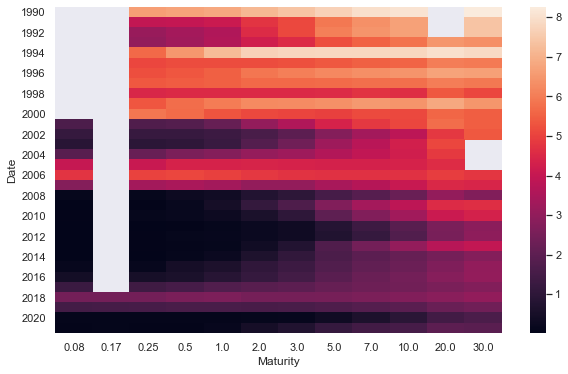

In [9]:

yields_resampled = yields.resample("Y").last()
yields_resampled.index = yields_resampled.index.year
yields_resampled.columns = [round(col, 2) for col in yields_resampled.columns]

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(yields_resampled, ax=ax)
ax.set_xlabel("Maturity")
ax.set_ylabel("Date")

Text(0, 0.5, 'Yield')

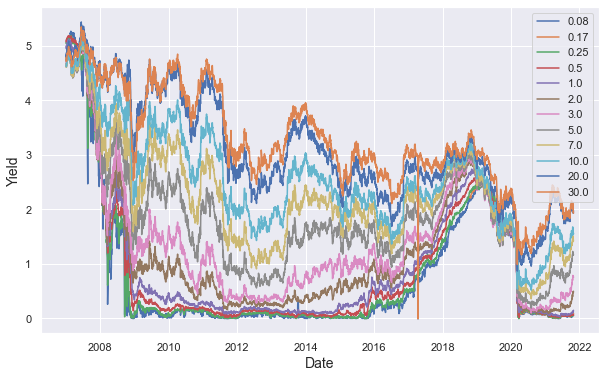

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
last_15y = yields.loc['2007':]
for col in last_15y.columns:
    ax.plot(last_15y.index, last_15y.loc[:, col], label=f'{round(col,2)}')
ax.legend()
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Yield', fontsize=14)

Text(0.5, 0, 'Maturity')

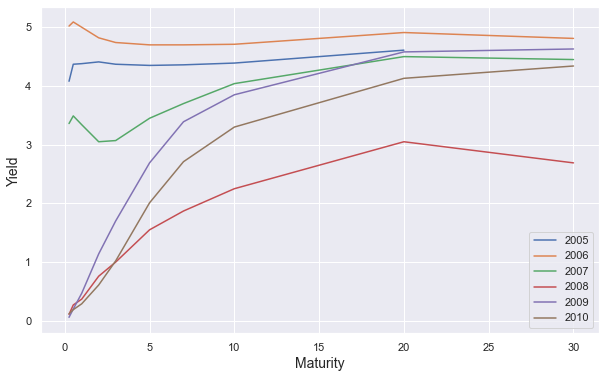

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
yields_crisis = yields.loc['2005':'2010', :].resample('Y').last()
for i in yields_crisis.index:
    ax.plot(yields_crisis.columns, yields_crisis.loc[i, :], label=f'{i.year}')
ax.legend()
ax.set_ylabel('Yield', fontsize=14)
ax.set_xlabel('Maturity', fontsize=14)

Text(0.5, 1.0, 'Correlation matrix')

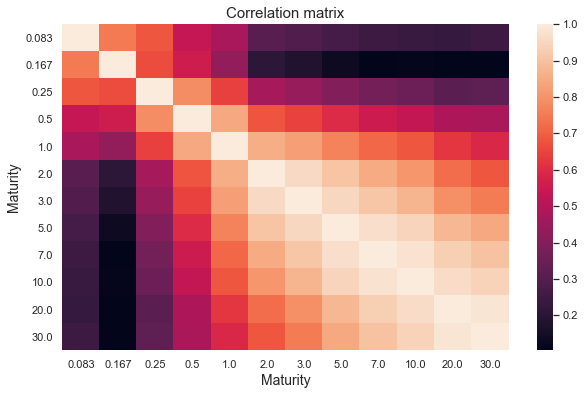

In [13]:
yields_diff = yields.diff()
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(yields_diff.corr())
ax.set_xlabel('Maturity', fontsize=14)
ax.set_ylabel('Maturity', fontsize=14)
ax.set_title('Correlation matrix', fontsize=15)

In [14]:
yields = yields.drop([0.083, 0.167], axis=1).dropna()
yields.head()

,0.25,0.50,1.00,2.00,3.00,5.00,7.00,10.00,20.00,30.00
dt,,,,,,,,,,
1993-10-01,2.98,3.11,3.35,3.84,4.18,4.72,5.03,5.34,6.12,5.98
1993-10-04,3.02,3.17,3.35,3.85,4.16,4.71,5.04,5.34,6.10,5.99
1993-10-05,3.06,3.20,3.38,3.86,4.18,4.72,5.05,5.35,6.12,6.01
1993-10-06,3.04,3.19,3.36,3.85,4.16,4.70,5.05,5.35,6.12,6.01
1993-10-07,3.05,3.17,3.35,3.83,4.15,4.69,5.05,5.33,6.11,6.01


In [18]:
yields.shape

(6030, 10)

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_yields = scaler.fit_transform(yields)

principal = PCA(n_components=3)
yields_transformed = principal.fit_transform(scaled_yields)

In [17]:
yields_transformed.shape

(6030, 3)

In [19]:
principal.components_.shape

(3, 10)

In [20]:
principal.explained_variance_ratio_

array([0.95153616, 0.04464538, 0.00294393])

In [21]:
principal.explained_variance_ratio_.sum()

0.9991254681079214

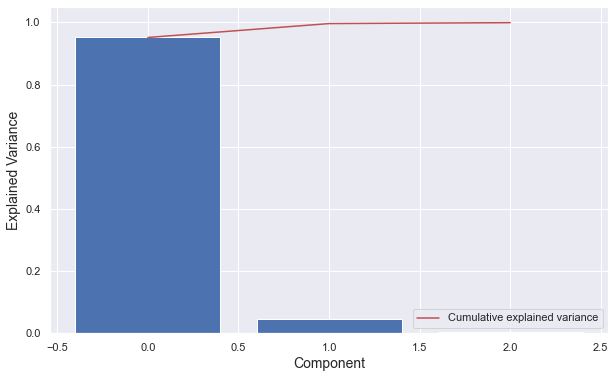

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(range(3), principal.explained_variance_ratio_)
ax.plot(range(3), np.cumsum(principal.explained_variance_ratio_), color='r', label='Cumulative explained variance')
ax.set_xlabel('Component', fontsize=14)
ax.set_ylabel('Explained Variance', fontsize=14)
ax.legend()

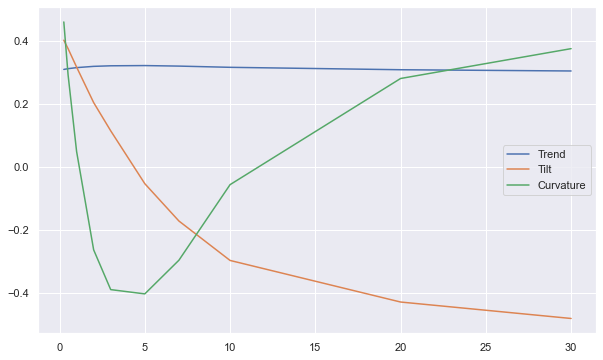

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
components = principal.components_
for i, label in zip(range(components.shape[0]), ['Trend', 'Tilt', 'Curvature']):
    ax.plot(yields.columns, components[i,:], label=label)
ax.legend()

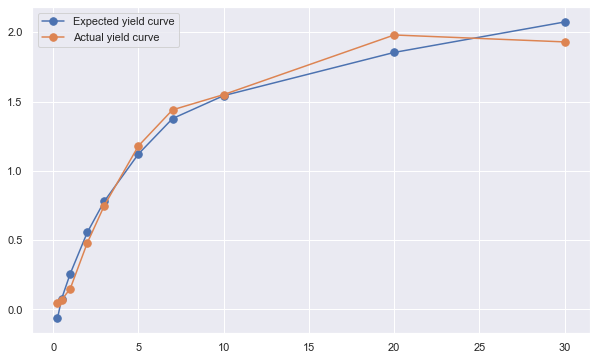

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yields.columns, scaler.inverse_transform((components.T*yields_transformed[-1,:]).sum(axis=1)), marker='.', markersize=15, label='Expected yield curve')
ax.plot(yields.columns, yields.iloc[-1, :], marker='.', markersize=15, label='Actual yield curve')
ax.legend()